# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

## Stack
- **Frontend:** Streamlit
- **Backend:** FastAPI
- **Database:** SQLite wit SQLAlchemy ORM
- **ML Environment:** Python (Jupyter Notebook, scikit-learn, pandas, nltk)
- **Datasets:** GitHub Issues Dataset and GitBugs/ms_vscode_bugs (Kaggle)
  - GitHub Issues: https://www.kaggle.com/datasets/davidshinn/github-issues?resource=download
  - GitBugs: https://www.kaggle.com/datasets/av9ash/gitbugs/data


---

# 01 Exploration Data Analysis

## Objective
Explore and clean the data to prepare it for model training in the next phase.

## Notebook Goals
1. Load and inspect the dataset.
2. Understand column types and distribution.
3. Handle missing values and duplicates.
4. Clean and normalize text fields (tokenization, stopwords, lemmatization).
5. Prepare a clean dataset for feature extraction and modeling

## Imports and Setup

In [1]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Export precessed DataFrame
import joblib

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Data

In [2]:
def load_data_sample(filename, n_sample=25000, chunksize=50000, random_state=42):
  """
  Samples n_sample rows from a large CSV without loading the full file into memory.

  Args:
      filename (str): path to CSV file
      n_sample (int, optional): Number of rows to sample. Defaults to 25000.
      chunksize (int, optional): Number of rows to read at a time. Defaults to 50000.
      random_state (int, optional): For reproducibility. Defaults to 42.
  """
  
  sampled_rows = []
  
  for chunk in pd.read_csv(filename, chunksize=chunksize):
    # Fraction to sample from current chunk
    frac = n_sample / len(chunk)
    sampled_rows.append(chunk.sample(frac=min(1, frac), random_state=random_state))
    
  sampled_df = pd.concat(sampled_rows).sample(n=n_sample, random_state=random_state).reset_index(drop=True)
  
  return sampled_df

In [3]:
# Github Issues
git_issues_filename = "../../data/raw/github_issues.csv"

git_issues_df = load_data_sample(git_issues_filename, n_sample=50000)
print("Github Issues shape: ", git_issues_df.shape)

Github Issues shape:  (50000, 3)


### Data Exploration

In [4]:
git_issues_df.head()

,issue_url,issue_title,body
0,"""https://github.com/LeoTindall/randomua/issues/2""",i can't reset the user agent,"after i installed randomua i can't download some add-ons from amo since amo now thinks i use firefox 52. i tried excluding addons.mozilla.org didn't work , setting the minimum spoofer version to 5..."
1,"""https://github.com/meyersbs/SPLAT/issues/23""",long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...
2,"""https://github.com/LaserWeb/LaserWeb4/issues/170""",raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...
3,"""https://github.com/tryashtar/minecraft-bugs/issues/313""",tab key not working for any function on mac,mojira ticket mc-334 https://bugs.mojang.com/browse/mc-334 <img src= https://secure.gravatar.com/avatar/c73b06d0f7d78154de104f2e546091db?d=mm&s=24 width=20 height=20> newell ellis https://bugs.moj...
4,"""https://github.com/MarlinFirmware/Marlin/issues/7968""",first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_..."


In [5]:
git_issues_df.tail()

,issue_url,issue_title,body
49995,"""https://github.com/celynwalters/cmus/issues/3""",show encodedby tag in library view,not sure if this is easy to do...
49996,"""https://github.com/rthotakura97/decentralized-database/issues/6""",asynch handling of requests,"currently, any requests received by our server handles them synchronously. we should make the handler as fast as possible and create a new thread to handle the actual logic. this new thread will n..."
49997,"""https://github.com/recharts/recharts/issues/927""",specify arbitrary domain for the cartesian x and y axes,"what is the current behavior? currently the domain accepts numbers, 'auto', or addition/subtraction from datamin and datamax. what is the expected behavior? i would like to be able to pass functio..."
49998,"""https://github.com/animenotifier/notify.moe/issues/46""",editform: bool type,add support for bool types in utils.editform .
49999,"""https://github.com/angular/angular-cli/issues/3968""",bug build --prod doesn't produce inline.hash.bundle.js.gz,"hi, ng build --prod --aot doesn't produce a gzip version of the inline.hash.bundle.js file. other files are gzip'd as expected. versions. angular-cli: 1.0.0-beta.24 node: 7.3.0 os: linux x64 @angu..."


In [6]:
git_issues_df.info()
git_issues_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   issue_url    50000 non-null  object
 1   issue_title  50000 non-null  object
 2   body         50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


,issue_url,issue_title,body
count,50000,50000,50000
unique,49990,48415,48661
top,"""https://github.com/cmty-test/cmty-repository-test/issues/2""",first from flow in uk south,first from flow in uk south
freq,4,833,833


## Handling missing values and duplicates

In [7]:
git_issues_df.isna().sum()

issue_url      0
issue_title    0
body           0
dtype: int64

In [8]:
duplicates = git_issues_df[git_issues_df.duplicated(subset='body', keep=False)]
print("Number of duplicate rows: ", duplicates.shape[0])

Number of duplicate rows:  1536


In [9]:
duplicates[['issue_title', 'body']].head(10)

,issue_title,body
11,missing card: -coin token set by ball,check if this card's info exists in deckdata.js
20,please add me - champs-sur-marne,hello! :wave: please add me as a collaborator to this repo.
36,first from flow in uk south,first from flow in uk south
40,first from flow in uk south,first from flow in uk south
54,first from flow in uk south,first from flow in uk south
57,first from flow in uk south,first from flow in uk south
63,contribute to the kill list,"to add a bit of a personal touch, add a programmer grievance of your own to the kill_list.md file."
64,first from flow in uk south,first from flow in uk south
121,missing card: -coin token set by bridge troll,check if this card's info exists in deckdata.js
172,5.1 program structure ~ 3 hrs,5.1 program structure ~ 3 hrs\neloquent javascript is a fantastic free book that would be great to eventually read in depth. let's jump into the second chapter. - start your toggl timer.\n- read c...


In [10]:
git_issues_df = git_issues_df.drop_duplicates(subset='body', keep='first')
print("Dataset shape after removing duplicates: ", git_issues_df.shape)

Dataset shape after removing duplicates:  (48661, 3)


## Challenge: Missing Priority Labels

one key challenge with the GitHub Issues dataset is that it **does not contain explicit priority or severity labels** (e.g., Critical, High, Medium, Low).

- **Impact:** Without a target variable, a supervised machine learning model cannot directly learn to classify issues by priority.
- **Common in real-word data:** Many open-source and internal issue trackers do not consistently label bugs with priority. This is a realistic scenario or software teams.

#### Solution: Weak Supervision via NLP

To address this, I will generate **pseudo-labels** for priority using **keyword-based NLP heuristics** on the issue text (`issue_title + body`):

- Define priority-related keywords for each class (Critical, High, Medium, Low).
- Assign the highest matching priority found in the text to each issue.
- Treat these derived labels as training targets for the ML model.

> Note: These labels are noisy approximations, but they allow me to **demonstrate the end-to-end ML pipeline** (text preprocessing -> feature extraction -> classification -> evaluation) in a realistic setting. Future work could involve human-labeled data or more sophisticated weak supervision techniques.

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def clean_text(text):
  """
  Cleans and preprocess text

  Args:
      text (str): The text that gets cleaned
  """
  
  text = str(text).lower()
  text = text.replace('_', ' ')
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # removes urls
  text = re.sub(r"[^a-z0-9\s]", "", text)               # removes punctuation
  tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
  return " ".join(tokens)

In [13]:
combined_text = git_issues_df['issue_title'].fillna('') + ' ' + git_issues_df['body'].fillna('')
git_issues_df['clean_text'] = combined_text.apply(clean_text)

git_issues_df.head()

,issue_url,issue_title,body,clean_text
0,"""https://github.com/LeoTindall/randomua/issues/2""",i can't reset the user agent,"after i installed randomua i can't download some add-ons from amo since amo now thinks i use firefox 52. i tried excluding addons.mozilla.org didn't work , setting the minimum spoofer version to 5...",cant reset user agent installed randomua cant download addons amo since amo think use firefox 52 tried excluding addonsmozillaorg didnt work setting minimum spoofer version 53 didnt work deactivat...
1,"""https://github.com/meyersbs/SPLAT/issues/23""",long strings of input on the command-line fail,long strings of input on the command-line cause a failure because those strings are too long to be a filename. - truncate the text of long inputs when creating the filename. - add an option to spe...,long string input commandline fail long string input commandline cause failure string long filename truncate text long input creating filename add option specify filename
2,"""https://github.com/LaserWeb/LaserWeb4/issues/170""",raster simulation rendering,! lw4_raster_display-simulate_quirks https://cloud.githubusercontent.com/assets/2752900/23263874/bf751316-f99c-11e6-827e-fee53d30c0d6.gif lw4 is a huge improvement over lw3 and i am appreciative o...,raster simulation rendering lw4 raster displaysimulate quirk lw4 huge improvement lw3 appreciative volunteer work gone contribute code paid nothing use program right criticism therefore intended c...
3,"""https://github.com/tryashtar/minecraft-bugs/issues/313""",tab key not working for any function on mac,mojira ticket mc-334 https://bugs.mojang.com/browse/mc-334 <img src= https://secure.gravatar.com/avatar/c73b06d0f7d78154de104f2e546091db?d=mm&s=24 width=20 height=20> newell ellis https://bugs.moj...,tab key working function mac mojira ticket mc334 img src width20 height20 newell elli oct 24 2012 mac tab key anything ex player list autofinish command player list key bound another key player li...
4,"""https://github.com/MarlinFirmware/Marlin/issues/7968""",first reading from adc without adc start adc in temperature.cpp,"temperature.cpp , version 1.1.x and 2.0 in fuction void temperature::isr static adcsensorstate adc_sensor_state = startupdelay; cpp switch adc_sensor_state { ...... if has_temp_0 case preparetemp_...",first reading adc without adc start adc temperaturecpp temperaturecpp version 11x 20 fuction void temperatureisr static adcsensorstate adc sensor state startupdelay cpp switch adc sensor state tem...


In [14]:
# Rule-based heuristic classifier
def assign_priority(text):
  text = str(text).lower()
  
  keywords = {
    "Critical": [
      "crash", "urgent", "block", "security", "data loss", "immediate", "leak", 
      "vulnerability", "malware", "corrupt", "unusable", "fatal", "system down",
      "cannot start", "inaccessible", "critical failure", "no access", "breach", 
      "exploit", "does not start", "infinite loop", "freeze system", "freezes"
      ],
    "High": [
      "fail", "error", "exception", "bug", "does not load", "timeout", "service down",
      "not working", "unable to", "stuck", "timeout", "incorrect", "wrong output",
      "not responding", "malfunction", "breaks", "regression", "unhandled",
      "unexpected", "missing file", "authentication", "deployment issue", "api error"
      ],
    "Medium": [
      "slow", "warning", "minor", "performance", "degraded", "inconsistent",
      "optimization", "delay", "unreliable", "resource usage", "partial failure",
      "sometimes", "temporary issue", "reduces performance", "fine-tuning", "occasionally",
      "lag", "refactor", "intermittent", "unreliable", "deprecated", "update", "load time"
      ],
    "Low": [
      "typo", "cosmetic", "suggestion", "enhancement", "refactor", "documentation",
      "readme", "cleanup", "alignment", "spacing", "grammar", "style", "formatting",
      "ui polish", "code comment", "naming", "color", "minor ui", "ui", "comment",
      "spelling", "non-critical", "translation", "ux", "improve"
      ]
  }
  
  for priority, words in keywords.items():
    if any(word in text for word in words):
      return priority
    
  return None

In [15]:
git_issues_df["priority"] = git_issues_df["clean_text"].apply(assign_priority)
git_issues_df.columns

Index(['issue_url', 'issue_title', 'body', 'clean_text', 'priority'], dtype='object')

In [16]:
git_issues_df["priority"].value_counts(dropna=False)

priority
None        20911
High        11772
Low          8137
Medium       4063
Critical     3778
Name: count, dtype: int64

In [17]:
processed_df = git_issues_df.dropna(subset=['priority']).copy()
print(processed_df.shape)

(27750, 5)


In [18]:
print(processed_df['priority'].value_counts)

<bound method IndexOpsMixin.value_counts of 1            High
2             Low
4          Medium
7            High
9             Low
           ...   
49987      Medium
49988        High
49990    Critical
49994        High
49999        High
Name: priority, Length: 27750, dtype: object>


In [19]:
sample_df = processed_df.dropna(subset=['priority']).sample(n=5000, random_state=42)

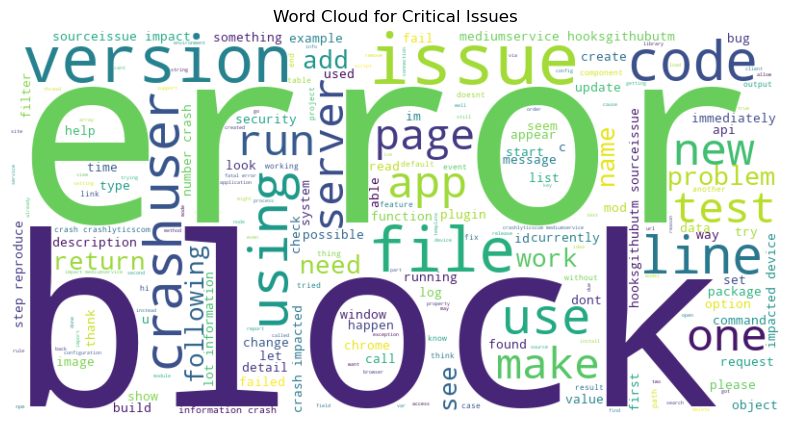

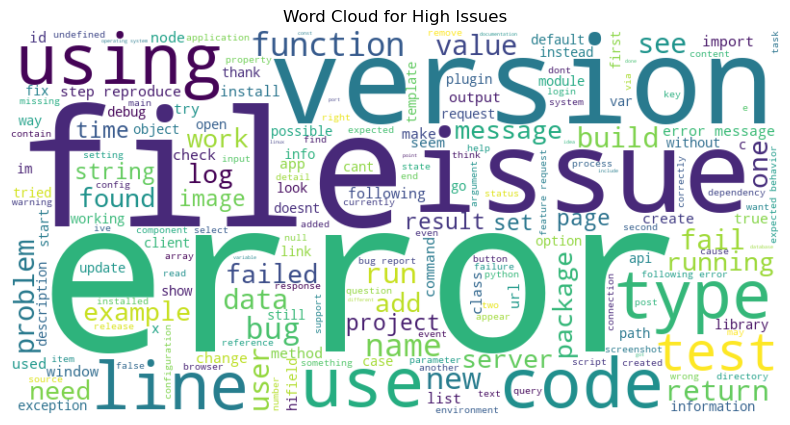

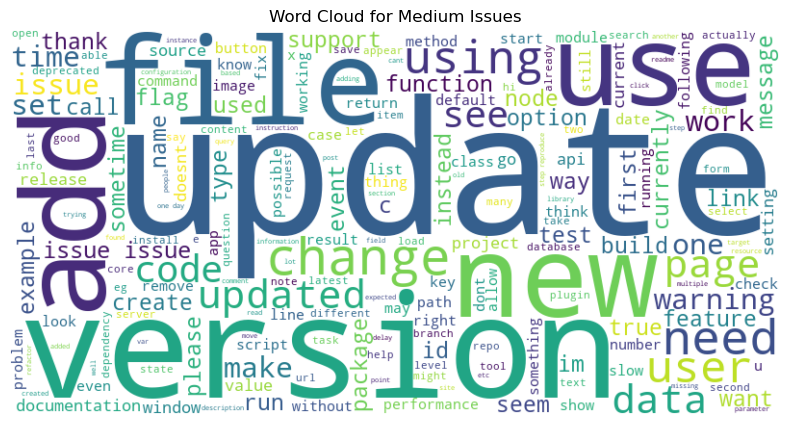

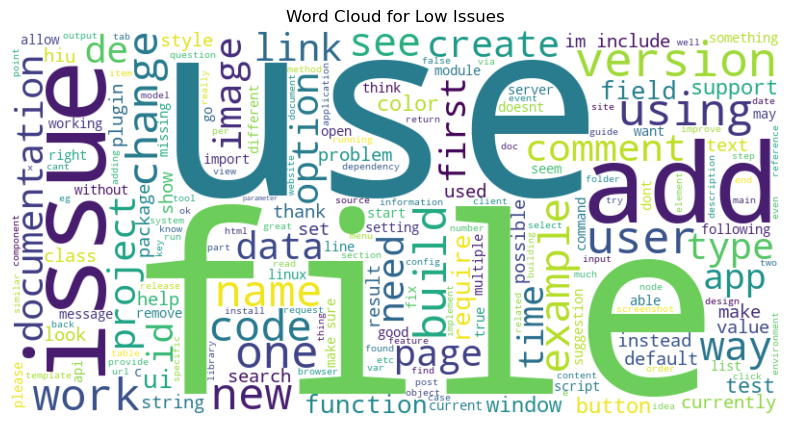

In [20]:
for priority in ['Critical', 'High', 'Medium', 'Low']:
  text = " ".join(sample_df[sample_df['priority']==priority]['clean_text'].tolist())
  wc = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(10,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for {priority} Issues")
  plt.show()

In [21]:
for priority in ['Critical', 'High', 'Medium', 'Low']:
  words = " ".join(sample_df[sample_df['priority']==priority]['clean_text']).split()
  top_words = Counter(words).most_common(15)
  print(f"{priority} top words: {top_words}\n")

Critical top words: [('error', 376), ('crash', 354), ('1', 325), ('version', 292), ('block', 274), ('issue', 270), ('file', 240), ('line', 186), ('code', 171), ('2', 158), ('using', 152), ('get', 143), ('user', 138), ('like', 137), ('use', 122)]

High top words: [('error', 2133), ('file', 1048), ('version', 959), ('issue', 829), ('1', 681), ('bug', 659), ('line', 633), ('code', 534), ('test', 529), ('get', 526), ('use', 522), ('using', 492), ('type', 463), ('2', 440), ('function', 409)]

Medium top words: [('update', 409), ('issue', 280), ('version', 235), ('would', 175), ('file', 167), ('add', 153), ('new', 143), ('use', 134), ('change', 132), ('need', 128), ('one', 128), ('using', 118), ('page', 116), ('like', 113), ('get', 112)]

Low top words: [('use', 308), ('file', 307), ('need', 304), ('would', 299), ('like', 280), ('add', 274), ('version', 274), ('using', 272), ('work', 254), ('issue', 248), ('new', 237), ('build', 229), ('make', 208), ('user', 207), ('1', 199)]



In [22]:
v = TfidfVectorizer(
  max_features=10000,
  ngram_range=(1, 2),
  min_df=5,
  max_df=0.9
)
X = v.fit_transform(processed_df['clean_text'])
y = processed_df['priority']

In [23]:
all_feature_names = v.get_feature_names_out()

for word in all_feature_names:
  indx = v.vocabulary_.get(word)
  if v.idf_[indx] < 4:
    print(f"{word} {v.idf_[indx]}")

add 3.179049075659035
also 3.3899273891392148
app 3.95724083671644
behavior 3.9628041334017685
bug 3.3270615205291687
build 3.462493853635301
call 3.957934558561812
case 3.856398139342389
change 3.511897313654602
check 3.820075278977698
code 3.0501462125649446
command 3.958628761991288
could 3.3879631378692805
create 3.7032331668398903
current 3.8914894591536595
currently 3.920476996026912
data 3.748908231009219
default 3.970504556471482
description 3.9889447953043726
doesnt 3.7097091743620942
dont 3.655442503003542
error 2.401800799829485
example 3.446137858906236
expected 3.4515601871030097
feature 3.838379633839711
file 2.798956216561932
find 3.885016944648042
first 3.831017637398642
fix 3.8146486753684066
following 3.387570750185219
found 3.801506311774872
function 3.682471175391461
get 2.936727545704099
help 3.768237997148886
hi 3.783858794961294
id 3.7938207876900414
im 3.356668329831453
image 3.8715595163057133
information 3.815250179145941
instead 3.81344675214679
issue 2.74491

In [24]:
idf_df = pd.DataFrame({'word': all_feature_names, 'idf': v.idf_})

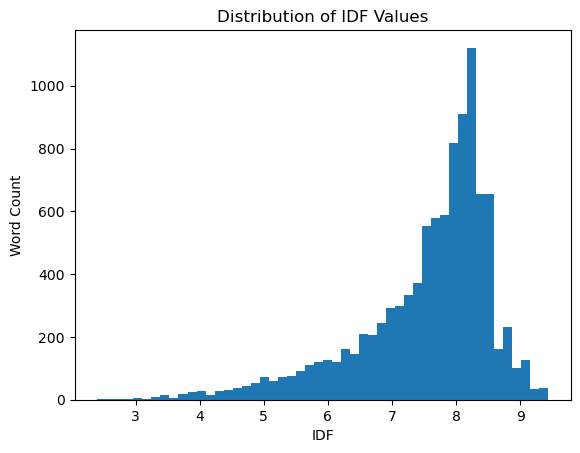

In [25]:
plt.hist(idf_df['idf'], bins=50)
plt.title("Distribution of IDF Values")
plt.xlabel("IDF")
plt.ylabel("Word Count")
plt.show()

In [26]:
threshold = np.percentile(idf_df['idf'], 10) # bottom 10%
common_words = idf_df[idf_df['idf'] <= threshold].sort_values('idf', ascending=True)

print(f"Common words: {len(common_words)}")

Common words: 1004


In [27]:
common_words.info

<bound method DataFrame.info of          word       idf
3067    error  2.401801
9465  version  2.639469
4786    issue  2.744912
3538     file  2.798956
9355    using  2.823426
...       ...       ...
7736   schema  5.999919
5519   matter  5.999919
8665     term  5.999919
2480   deploy  5.999919
6437  pattern  5.999919

[1004 rows x 2 columns]>

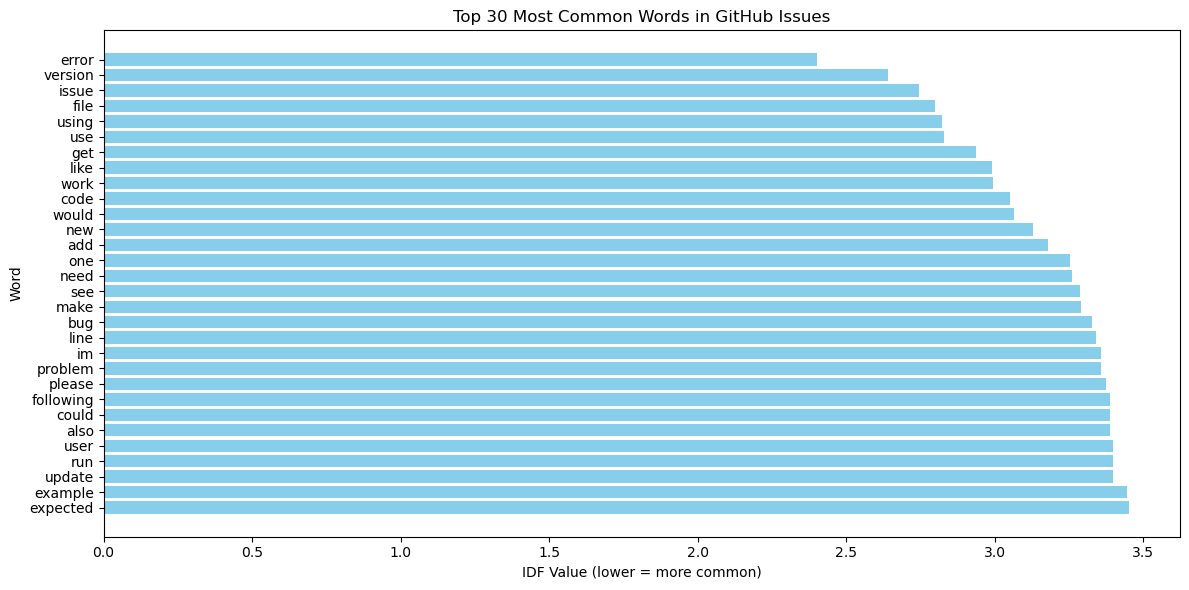

In [28]:
top_common = common_words.head(30)

plt.figure(figsize=(12, 6))
plt.barh(top_common['word'], top_common['idf'], color='skyblue')
plt.xlabel('IDF Value (lower = more common)')
plt.ylabel('Word')
plt.title('Top 30 Most Common Words in GitHub Issues')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:

joblib.dump(processed_df, '../../data/processed/processed_github_issues_df.joblib')
print("Processed DataFrame saved successfully!")

Processed DataFrame saved successfully!


In [30]:
joblib.dump(X, '../../data/processed/tfidf/X_tfidf.joblib')
joblib.dump(y, '../../data/processed/tfidf/y_labels.joblib')
joblib.dump(v, '../../data/processed/tfidf/tfidf_vectorizer.joblib')
print("TF-IDF matrix, labels, and vectorizer saved successfully!")

TF-IDF matrix, labels, and vectorizer saved successfully!
